<a href="https://colab.research.google.com/github/Nimish-4/Web_scraping_NLP/blob/main/Project_scraping_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Function to get the response object from Yahoo.com's finance page
# Top news articles of the moment, in the response object, are <a> tags of class 'js-content-viewer'

def get_page(url):
    response = requests.get(url)
    if not response.ok:
        print('Status code:', response.status_code)
        raise Exception('Failed to load page {}'.format(url))
    page_content = response.text
    doc = BeautifulSoup(page_content, 'html.parser')
    return doc


my_url = "https://finance.yahoo.com/news"
response = requests.get(my_url)

doc = get_page(my_url)
a_tags = doc.find_all('a', {'class': "js-content-viewer"})

In [19]:
# Getting headlines of each news article and converting to

news_list = []

for i in range(len(a_tags)):
      news = a_tags[i].text
      news_list.append(news)
      print("Headline " + str(i+1) + ":  " + news)

news_df = pd.DataFrame(news_list)
news_df.to_csv('Market_News')

Headline 1:  China police detain some Evergrande wealth management staff
Headline 2:  New York employers must include pay rates in job ads under new state law
Headline 3:  UPDATE 1-Union starts further 24-hour stoppage at Chevron's Australian LNG facilities
Headline 4:  Five killed, one wounded in Donetsk, Russian-installed official says
Headline 5:  UPDATE 1-Russia says it thwarted Ukraine drone attacks on Crimea
Headline 6:  Trafigura Wrestles With Future of Metals Unit after Losses
Headline 7:  N. Korea's Kim to visit several Russian food enterprises -RIA
Headline 8:  Auto workers' union calls talks with Ford productive as strike continues
Headline 9:  UPDATE 3-North Korea's Kim, Russia talk up military ties in new 'heyday' - KCNA
Headline 10:  Caught in a lie, CEO of embattled firm caring for NYC migrants resigns


In [20]:
# Searching for and saving the links to articles embedded in the <a> tags

links = []
url = "https://finance.yahoo.com"

for anchor in a_tags:
  href=anchor.get('href')
  links.append(url+href)

print(links)

['https://finance.yahoo.com/news/china-police-detain-evergrande-wealth-042711759.html', 'https://finance.yahoo.com/news/york-employers-must-pay-rates-040602947.html', 'https://finance.yahoo.com/news/1-union-starts-further-24-031900508.html', 'https://finance.yahoo.com/news/five-killed-one-wounded-donetsk-012657847.html', 'https://finance.yahoo.com/news/1-russia-says-thwarted-ukraine-011950852.html', 'https://finance.yahoo.com/news/trafigura-wrestles-future-metals-unit-010810305.html', 'https://finance.yahoo.com/news/n-koreas-kim-visit-several-003120508.html', 'https://finance.yahoo.com/news/auto-workers-union-calls-talks-221039388.html', 'https://finance.yahoo.com/news/1-north-koreas-kim-discusses-214014624.html', 'https://finance.yahoo.com/news/caught-lie-ceo-embattled-firm-205523303.html']


In [21]:
# Extracting the text from the actual news article using the links stored before

articles = []

for link in links:

  if link.find('video')==-1:                      # Excluding news links with videos instead of articles

    curr = ""
    res = requests.get(link)
    article = BeautifulSoup(res.text, 'html.parser')
    outer = article.find_all('div',{'class':'caas-body'})
    paras = outer[0].find_all('p')

    for i in range(1,len(paras)-3):               # Excluding <p> tags with irrelevant info. like date, time, author etc.
      curr+=paras[i].text

    articles.append(curr)

print(articles)
print('Number of articles: ',len(articles))

['"Recently, public security organs took criminal compulsory measures against Du and other suspected criminals at Evergrande Financial Wealth Management Co.," Shenzhen city police said in a social media statement on Saturday night.During protests by disgruntled investors at Evergrande\'s Shenzhen headquarters in 2021, Du Liang was identified by staff as general manager and legal representative of Evergrande\'s wealth management division.Reuters could not confirm that Du was among those detained, and the police statement did not specify the number of people detained, the charges or the date they were taken into custody.China Evergrande did not immediately respond to a request for comment on Sunday outside of normal business hours.The police said the investigation into the financial management unit was ongoing and urged investors to report any further financial crimes.China Evergrande, the world\'s most indebted property developer, is at the centre of a crisis in China\'s property sector

In [22]:
# Using TF-IDF to turn words from the articles into vectors

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1),        # Considering only 1-grams
                        min_df = 0.2,             # Cut words present in less than 20% of documents
                        max_df = 0.5)             # Cut words present in more than 50% of documents

tfidf = vectorizer.fit_transform(articles)
print(tfidf.shape)

(10, 126)


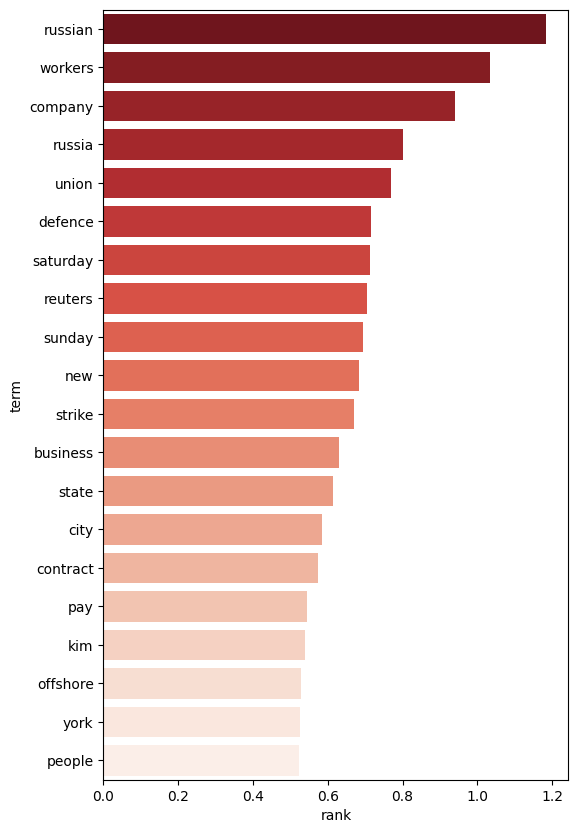

In [23]:
# Function to call the top ranked words in the vectorizer and using seaborn to visualize them

def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms=vectorizer.get_feature_names_out(), feature_matrix=tfidf)

fig, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette='Reds_r', ax=ax);

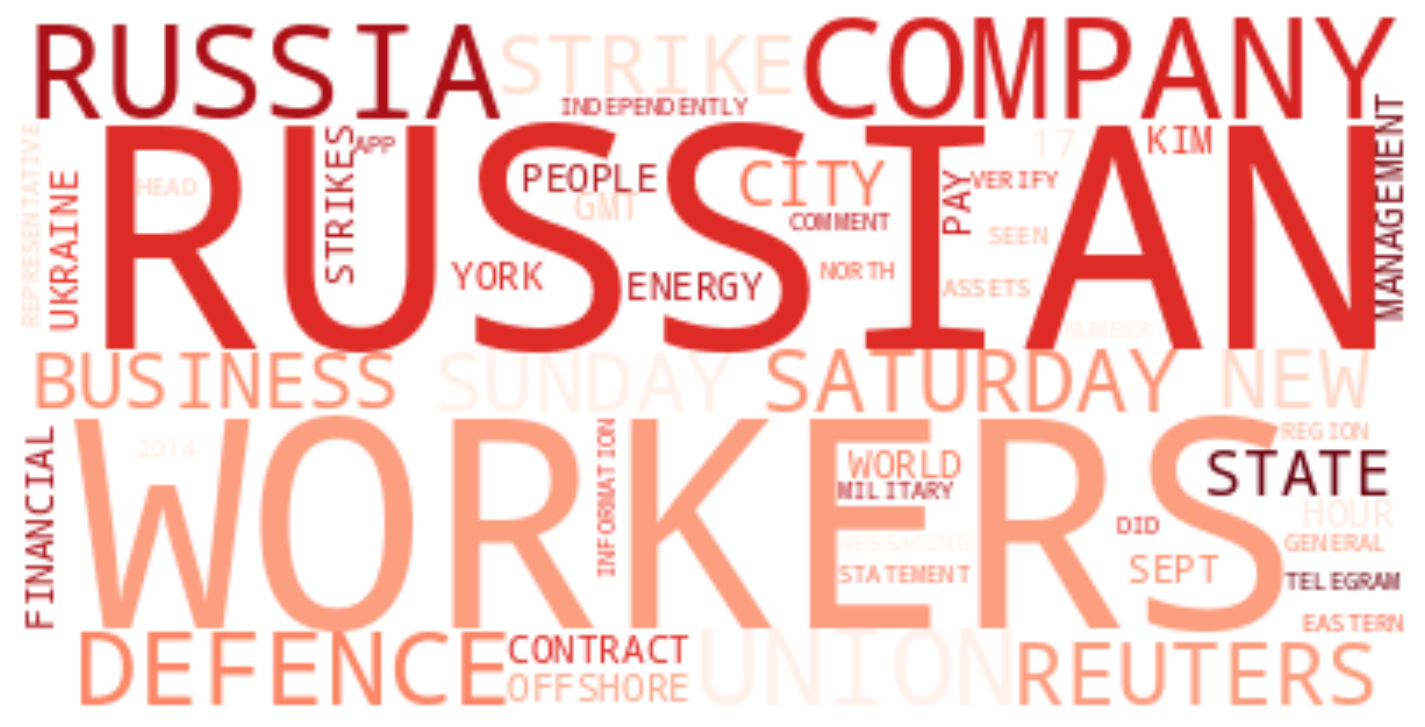

In [24]:
# Make a word cloud of the most frequent words using tfidf frequencies

dic = {ranked.loc[i,'term'].upper(): ranked.loc[i,'rank'] for i in range(0,len(ranked))}

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',
                      max_words=50,
                      colormap='Reds').generate_from_frequencies(dic)

fig = plt.figure(1,figsize=(12,15),dpi=150)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()
